In [9]:
import rioxarray as rxr
import xarray as xr
import rasterio as rio
import earthpy.plot as ep
import geopandas as gpd
import numpy as np
from shapely.geometry import shape, box
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

In [ ]:
# Normalized Burn Ratio (NBR)

# The Normalized burn ratio (NBR) is used to identify burned areas. The formula is similar to a normalized difference 
# vegetation index (NDVI), except that it uses near-infrared (NIR) and shortwave-infrared (SWIR) portions of the 
# electromagnetic spectrum (Lopez, 1991; Key and Benson, 1995).

# For this reason, the NBR ratio works better in areas like the United States where plant regeneration is expected to
# occur more slowly. In areas like the tropics which are wet and characterized by rapid regrowth, NBR may be less effective.

# This is calculated by (NIR - SWIR-2) / (NIR + SWIR-2)

# The Normalized Burn Ratio is most powerful as a tool to better understand fire extent and severity when used after 
# calculating the difference between pre and post fire conditions. This difference is best measured using data collected
# immediately before the fire and then immediately after the fire. NBR is less effective if time has passed and vegetation
# regrowth / regeneration has begun after the fire. Once vegetation regeneration has begun, the fire scar will begin to 
# reflect a stronger signal in the NIR portion of the spectrum because healthy plants reflect strongly in the NIR portion
# due to the properties of chlorophyll).

# For this reason, the NBR ratio works better in areas like the United States where plant regeneration is expected to 
# occur more slowly. In areas like the tropics which are wet and characterized by rapid regrowth, NBR may be less effective.

# delta_NBR = pre_NBR - post_NBR

# SEVERITY LEVEL        dNBR RANGE
# Enhanced Regrowth     < -.1
# Unburned              -.1 to +.1
# Low Severity          +.1 to +.27
# Moderate Severity     +.27 to +.66
# High Severity         > .66

# It is important to know that this index is also sensitive to water and thus sometimes, pixels that are 
# classified as “high severity” may actually be water. Because of this, it is important to mask out areas of water
# PRIOR to performing any quantitative analysis on the difference NBR results.

# Shockingly good from linkedin:
# https://www.linkedin.com/pulse/ndvi-ndbi-ndwi-calculation-using-landsat-7-8-tek-bahadur-kshetri/



In [3]:
with rxr.open_rasterio('20230803_TOA/LC09_L1TP_180035_20230803_20230804_02_T1_TOA_STACKED.tif') as ds:
    post_rhodes = ds
    
with rxr.open_rasterio('20230710_TOA/LC08_L1TP_180035_20230710_20230718_02_T1_TOA_STACKED.tif') as ds:
    pre_rhodes = ds

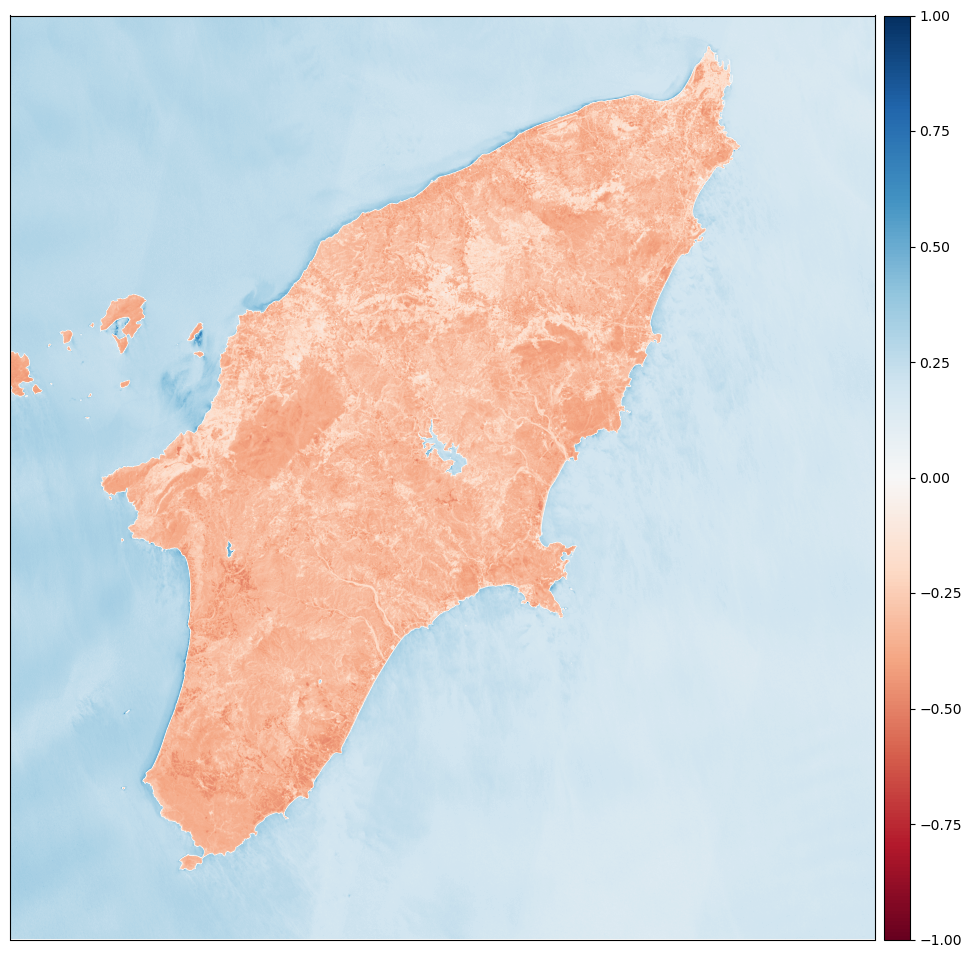

<Axes: >

In [4]:
# Use modified NDWI to find water (green - SWIR-1 / green + SWIR-1)
rhodes_water = (pre_rhodes[2] - pre_rhodes[5]) / (pre_rhodes[5] + pre_rhodes[2])

ep.plot_bands(rhodes_water, cmap = "RdBu", vmin = -1, vmax = 1)

In [5]:
# Calculate dNBR
post_NBR = (post_rhodes[4] - post_rhodes[6]) / (post_rhodes[6] + post_rhodes[4])

pre_NBR = (pre_rhodes[4] - pre_rhodes[6]) / (pre_rhodes[6] + pre_rhodes[4])

delta_NBR = pre_NBR - post_NBR

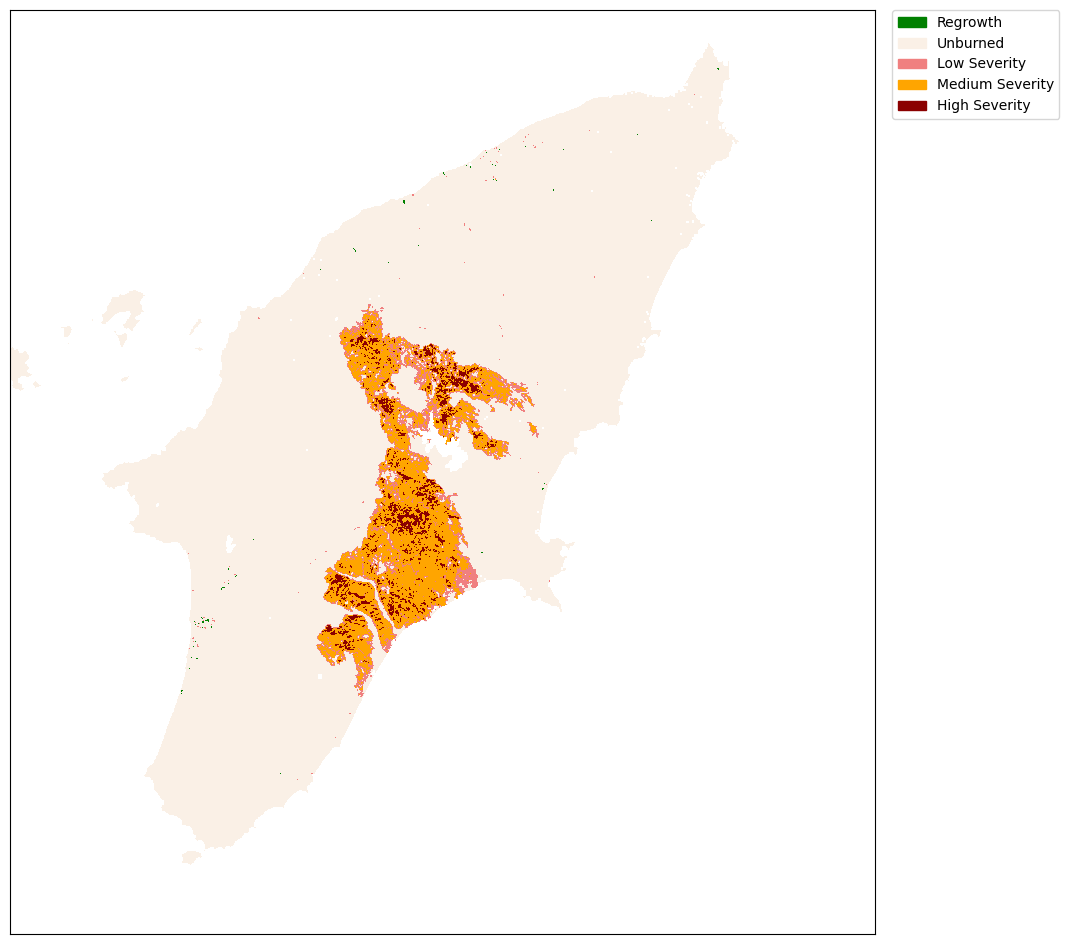

In [10]:
# Categorize using np.digitize - can always adjust slightly to get ideal results
class_bins = [-0.1, 0.1, .27, .66]

classified_NBR = xr.apply_ufunc(np.digitize, delta_NBR, class_bins)

# mask water
classified_NBR_masked = classified_NBR.where(rhodes_water < 0, 255)

classified_NBR_masked = classified_NBR_masked.astype(np.uint8) # recall uint8 is 0-255, int8 is -127 to 128
classified_NBR_masked.rio.write_nodata(255, inplace = True) # set nodata value

f, ax = plt.subplots(figsize = (12,12))

colors = ['green', 'linen', 'lightcoral', 'orange', 'darkred']
forest = ['Regrowth', "Unburned", "Low Severity", "Medium Severity", "High Severity"]

# Custom colorbar
bins = [-.5, .5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, 
                    len(colors))

# Mask out water in image - raster still contains water as nodata (255)
ep.plot_bands(classified_NBR_masked.where(rhodes_water < 0), cmap = cmap, norm = norm, ax = ax, cbar = False) #

patches = [mpatches.Patch(color=colors[i], label = forest[i]) for i in range(5)]
plt.legend(handles=patches , bbox_to_anchor=(1.02, 1), loc = 2, borderaxespad=0. );

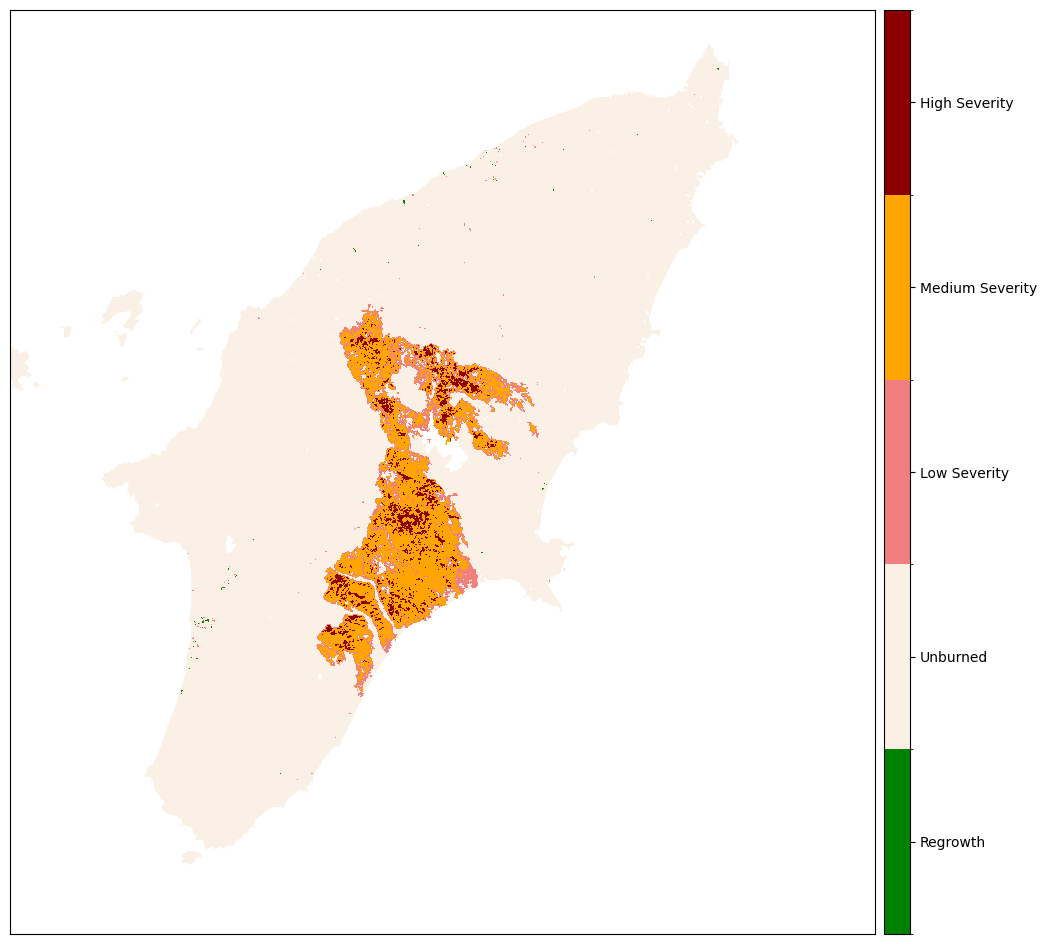

In [11]:
# alternative colorbar using ep.colorbar
f, ax = plt.subplots(figsize = (12,12))

colors = ['green', 'linen', 'lightcoral', 'orange', 'darkred']
burn_severity = ['Regrowth', "Unburned", "Low Severity", "Medium Severity", "High Severity"]

# Custom colorbar
bins = [-.5, .5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, 
                    len(colors))

# Mask out water in image - raster still contains water as nodata (255)
ep.plot_bands(classified_NBR_masked.where(rhodes_water < 0), cmap = cmap, norm = norm, ax = ax, cbar = False) #

cbar = ep.colorbar(ax.get_images()[0])

cbar.set_ticks(np.unique(classified_NBR).squeeze())
cbar.set_ticklabels(burn_severity)

<Axes: >

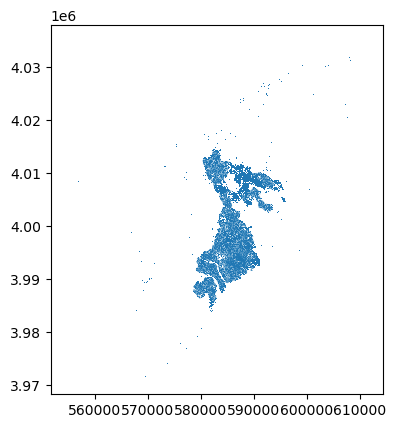

In [12]:
# Create a polygon of the fire affected area
# Speed of this process can be significantly increased if it is classified first.
import rasterio as rio

burned = rio.features.shapes(
    classified_NBR_masked, 
    mask = (classified_NBR_masked > 1) & (classified_NBR_masked != 255), # burn areas only, remember to exclude nodata (255)
    transform = classified_NBR_masked.rio.transform()
)

polygons = list(burned)
        
geom = [shape(x[0]) for x in polygons]
values = [x[1] for x in polygons]
burned_df = gpd.GeoDataFrame({"burn_id": values, "geometry": geom}, crs = post_rhodes.rio.crs)

burned_df.plot()

In [13]:
# Area of each polygon
burned_df["area"] = burned_df.area / 1000000

# The geodataframe can also be used to calculate summary statistics, e.g. total severely burned area = 30km2
burned_df[["burn_id", "area"]].groupby("burn_id").agg("sum")

,area
burn_id,
2.0,35.2692
3.0,114.1182
4.0,29.8026


In [14]:
# We can clean the geodataframe by removing all single pixels
# Single pixels have area 900m2 - can remove if necessary
# From 14k polygons to 7k polygons

# Uncomment if you want to clean
# burned_df_cleaned = burned_df[burned_df["area"] > 0.0009]

burned_df.to_file("rhodes_dNBR.geojson", driver = "GeoJSON")

In [15]:
# Save raster

classified_NBR_masked.rio.to_raster("rhodes_dNBR.tif")